In [1]:
### Import all the Dependencies
import numpy as np
import tensorflow as tf
import traceback
import contextlib
from tensorflow.keras import models, layers
import keras.api._v2.keras as keras
import matplotlib.pyplot as plt
from IPython.display import HTML

In [2]:
### Set all the Constants
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [3]:
### Import data into tensorflow dataset object
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

In [6]:
### Visualize some of the images from our dataset
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 1 0 0 0 1 0 1 0 1 0 1 2 1 2 0 0 1 0 1 1 0 1 0 1 0 1 1 0 1]


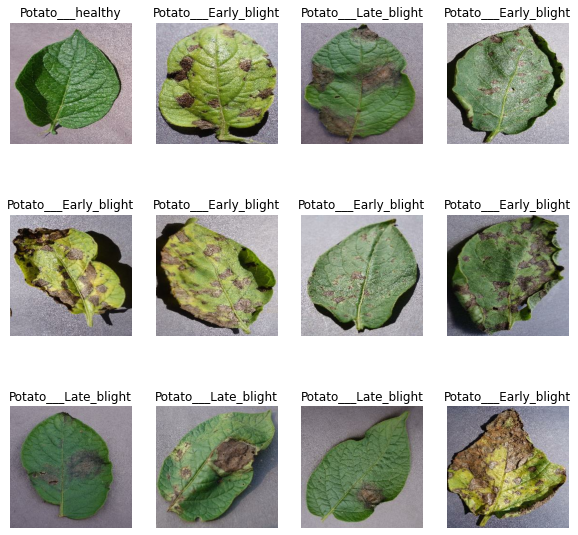

In [7]:
### Visualize some of the images from our dataset
plt.figure(figsize=(10, 10))        
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [8]:
### different commands for the previous cell for some errors till find the solution
## print out the batch shape (number of images, row, columb, channels).
## label the batch for every file (0 for first batch,......)
#for image_batch, labels_batch in dataset.take(1):
#    print(image_batch.shape)
#    print(labels_batch.numpy())
    
## print out the image but in tensor type
# for image_batch, label_batch in dataset.take(1):
#    print(image_batch[0])
    
## print out the image but in numpy type    
# for image_batch, label_batch in dataset.take(1):
#    print(image_batch[0].numpy())
    
## print out the batch shape and size  
# for image_batch, label_batch in dataset.take(1):
#    print(image_batch[0].shape)
    
## show the image but since the value is float it wont be good so we change it to uint8 type   
# for image_batch, label_batch in dataset.take(1):
#    plt.imshow(image_batch[0].numpy())
    
## show the image but in unit8 type to show right way    
# for image_batch, label_batch in dataset.take(1):
#    plt.imshow(image_batch[0].numpy().astype("uint8"))
    
## removing the axis    
#for image_batch, label_batch in dataset.take(1):
#    plt.imshow(image_batch[0].numpy().astype("uint8"))
#    plt.axis("off")

## label the image while showing it
# for image_batch, label_batch in dataset.take(1):
#    plt.imshow(image_batch[0].numpy().astype("uint8"))
#    plt.title(class_names[label_batch[0]])
#    plt.axis("off")

## if we do this it will still show us one image
# for image_batch, label_batch in dataset.take(1):
#    for i in range(12):
#        plt.imshow(image_batch[i].numpy().astype("uint8"))
#        plt.title(class_names[label_batch[i]])
#        plt.axis("off")

## use this to show more than image with ordered 3,4 but it wont be good bec the labeling and images will be interfering with each other
# or image_batch, label_batch in dataset.take(1):
#    for i in range(12):
#        ax = plt.subplot(3,4,i+1)
#        plt.imshow(image_batch[i].numpy().astype("uint8"))
#        plt.title(class_names[label_batch[i]])
#        plt.axis("off")

## add that to solve th eprevious problem
# plt.figure(figsize=(10, 10))        
# for image_batch, label_batch in dataset.take(1):
#    for i in range(12):
#        ax = plt.subplot(3,4,i+1)
#        plt.imshow(image_batch[i].numpy().astype("uint8"))
#        plt.title(class_names[label_batch[i]])
#        plt.axis("off")

In [9]:
### Function to Split Dataset
## Dataset should be bifurcated into 3 subsets, namely:
# 1. Training: Dataset to be used while training
# 2. Validation: Dataset to be tested against while training
# 3. Test: Dataset to be tested against after we trained a model

In [10]:
len(dataset)

68

In [11]:
### this is how we split our algorithm to get the result
## 80% ==> training
## 20% ==> 10% validation, 10% test

In [12]:
### to calculate the size of first few samples
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [13]:
### to detrimine how many images we will start training or skiping we need to calculate
### since we decided our training will be 80% then we will multiply this by len(dataset)
train_ds = dataset.take(54) # can be done by : arr[:54]
len(train_ds)

54

In [14]:
test_ds = dataset.skip(54) # can be done by : arr[54:]
len(test_ds)

14

In [15]:
val_size = 0.1
len(dataset) * val_size

6.800000000000001

In [16]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [17]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [18]:
### To sum up how to split the dataset in one function to be easier and more efficient and faster
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [19]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [20]:
len(train_ds)

54

In [21]:
len(val_ds)

6

In [22]:
len(test_ds)

8

In [23]:
### Cache, Shuffle, and Prefetch the Dataset
## this will save the image in the memory if needed bec using cashe()
## prefetch improve performance for whose have GPU and CPU bec it save time while one loading and other training 
## AUTOTUNE for the deviec to decide and edit itself

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [24]:
### Building the Model
## Creating a Layer for Resizing and Normalization
## Before we feed our images to network, we should be resizing it to the desired size. 
## Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256).
## This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

## You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

## we will resize the images so if another image not same size it will take care of it
## rescale for making the value of image from RGB (0 - 255) to (0 - 1)

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [25]:
### Data Augmentation
# Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.
# it is used to make more types of images of the same image with different conditions better and easier than get 4 separate images bec it will make it (Flipping(horizontal or vertical), Contrast, Rotation, Zoom, and maybe more than 4.......)

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [26]:
#### Applying Data Augmentation to Train Dataset
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [28]:
### Compiling the Model
## We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [29]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds,
)

Epoch 1/50
54/54 [==============================] - 147s 3s/step - loss: 0.8667 - accuracy: 0.5446 - val_loss: 0.7281 - val_accuracy: 0.6146
Epoch 2/50
54/54 [==============================] - 138s 3s/step - loss: 0.5126 - accuracy: 0.7755 - val_loss: 0.3773 - val_accuracy: 0.8281
Epoch 3/50
54/54 [==============================] - 138s 3s/step - loss: 0.2904 - accuracy: 0.8785 - val_loss: 0.2268 - val_accuracy: 0.9115
Epoch 4/50
54/54 [==============================] - 140s 3s/step - loss: 0.1981 - accuracy: 0.9230 - val_loss: 0.3717 - val_accuracy: 0.8646
Epoch 5/50
54/54 [==============================] - 138s 3s/step - loss: 0.1870 - accuracy: 0.9294 - val_loss: 0.1304 - val_accuracy: 0.9375
Epoch 6/50
54/54 [==============================] - 138s 3s/step - loss: 0.1723 - accuracy: 0.9294 - val_loss: 0.2039 - val_accuracy: 0.9167
Epoch 7/50
54/54 [==============================] - 139s 3s/step - loss: 0.1482 - accuracy: 0.9491 - val_loss: 0.1580 - val_accuracy: 0.9427
Epoch 8/50
54

In [30]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 6s 564ms/step - loss: 0.0180 - accuracy: 0.9922


In [31]:
scores

[0.018026120960712433, 0.9921875]

In [ ]:
# here we will be looking at some history functions and parameters

In [32]:
history

In [33]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [34]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [35]:
history.history['accuracy']

[0.5445601940155029,
 0.7754629850387573,
 0.8784722089767456,
 0.9230324029922485,
 0.9293981194496155,
 0.9293981194496155,
 0.9490740895271301,
 0.9490740895271301,
 0.9334490895271301,
 0.9484953880310059,
 0.9502314925193787,
 0.9519675970077515,
 0.9438657164573669,
 0.9519675970077515,
 0.9490740895271301,
 0.9623842835426331,
 0.9641203880310059,
 0.9756944179534912,
 0.9699074029922485,
 0.9739583134651184,
 0.96875,
 0.9699074029922485,
 0.9832175970077515,
 0.9797453880310059,
 0.9699074029922485,
 0.9866898059844971,
 0.9820601940155029,
 0.9884259104728699,
 0.9728009104728699,
 0.9641203880310059,
 0.9855324029922485,
 0.9814814925193787,
 0.9820601940155029,
 0.9849537014961243,
 0.9722222089767456,
 0.9866898059844971,
 0.9797453880310059,
 0.9890046119689941,
 0.9913194179534912,
 0.9878472089767456,
 0.9814814925193787,
 0.9837962985038757,
 0.9907407164573669,
 0.9809027910232544,
 0.9733796119689941,
 0.9930555820465088,
 0.9832175970077515,
 0.9924768805503845,
 0.

In [36]:
len(history.history['accuracy'])

50

In [38]:
# plotting the data history on chart
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

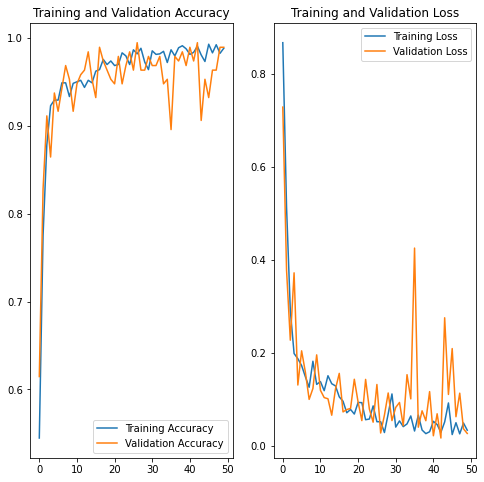

In [39]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

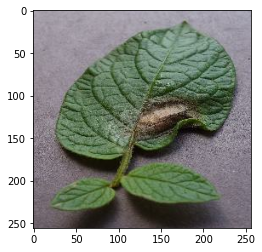

In [43]:
### to acess a batch and show any image inside it we use that
# import numpy as np
# for images_batch, labels_batch in test_ds.take(1):
#    plt.imshow(images_batch[0].numpy().astype('uint8'))

In [ ]:
### this function to convert the output of the prediction function to what we need in values
#np.argmax( , , )

In [ ]:
# note that class_names [] is for convert the value of which patch as we saw at first [0,1,2] to the name of this patch

first image to predict
actual label: Potato___Early_blight
predicted label: Potato___Early_blight


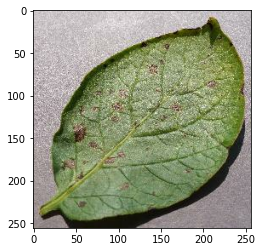

In [49]:
### This for show the prediction
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [50]:
### its a function that taking a model and images as an input and telling you if its a predicted_class or confidence(100%)
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

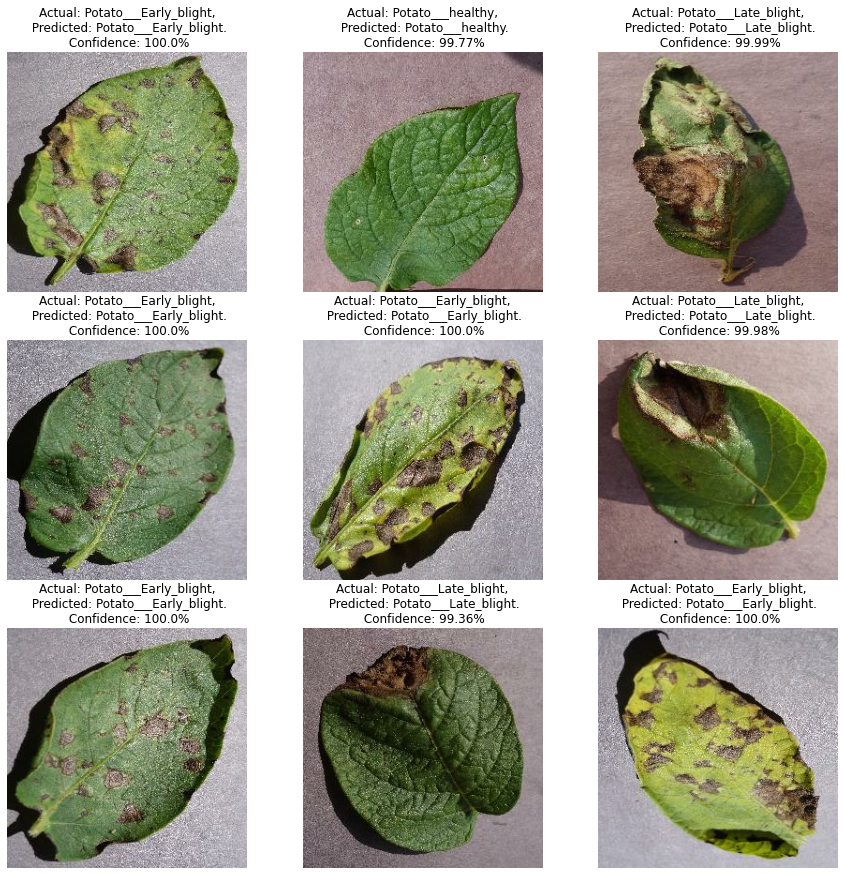

In [51]:
### this for take specific number of images in that example we took only 9 and that can be changed by the value of 9 and show it in plot withe the predicted_classes or the confidence
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [ ]:
### this code to save the several model versions for any changes in the future and change the value of 1 to 2 and so on 
# model_version = 1
# model.save(f"../models/{model_version}")

In [54]:
### this code to save the several model versions for any changes in the future without any change in the model value its auto done
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/2\assets
